In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/exercises/ecoli.csv

File ‘ecoli.csv’ already there; not retrieving.



In [3]:
cols = ['Name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'target']
data_df = pd.read_csv('ecoli.csv', sep='[\s,]{1,20}', names=cols)
print(data_df)
print(data_df.columns)

           Name   mcg   gvh   lip  chg   aac  alm1  alm2 target
0     AAT_ECOLI  0.49  0.29  0.48  0.5  0.56  0.24  0.35     cp
1    ACEA_ECOLI  0.07  0.40  0.48  0.5  0.54  0.35  0.44     cp
2    ACEK_ECOLI  0.56  0.40  0.48  0.5  0.49  0.37  0.46     cp
3    ACKA_ECOLI  0.59  0.49  0.48  0.5  0.52  0.45  0.36     cp
4     ADI_ECOLI  0.23  0.32  0.48  0.5  0.55  0.25  0.35     cp
..          ...   ...   ...   ...  ...   ...   ...   ...    ...
331  TREA_ECOLI  0.74  0.56  0.48  0.5  0.47  0.68  0.30     pp
332  UGPB_ECOLI  0.71  0.57  0.48  0.5  0.48  0.35  0.32     pp
333  USHA_ECOLI  0.61  0.60  0.48  0.5  0.44  0.39  0.38     pp
334  XYLF_ECOLI  0.59  0.61  0.48  0.5  0.42  0.42  0.37     pp
335  YTFQ_ECOLI  0.74  0.74  0.48  0.5  0.31  0.53  0.52     pp

[336 rows x 9 columns]
Index(['Name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'target'], dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [4]:
feature_df = data_df.drop(columns=['Name', 'target'])
target_df = data_df['target']
print(target_df)

0      cp
1      cp
2      cp
3      cp
4      cp
       ..
331    pp
332    pp
333    pp
334    pp
335    pp
Name: target, Length: 336, dtype: object


In [5]:
def process_pls(name="cp"):
  """
  This function processes a string of the protein localization site
  and encodes it as an integer number.
  """
  if type(name) != str:
    return name

  if name == "cp":
    return 0.
  elif name == "im":
    return 1.
  elif name == "imS":
    return 2.
  elif name == "imL":
    return 3.
  elif name == "imU":
    return 4.
  elif name == "om":
    return 5.
  elif name == "omL":
    return 6.
  elif name == "pp":
    return 7.

In [6]:
target_df = target_df.apply(lambda x: process_pls(x))

In [7]:
print(target_df)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
331    7.0
332    7.0
333    7.0
334    7.0
335    7.0
Name: target, Length: 336, dtype: float64


In [8]:
print(feature_df.shape)

(336, 7)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(feature_df.values, 
                                                    target_df.values, 
                                                    test_size=0.33)
N, D = X_train.shape

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
model = nn.Sequential(
    nn.Linear(D, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(128, 16),
    nn.ReLU(),
    nn.BatchNorm1d(16),
    nn.Dropout(p=0.2),
    nn.Linear(16, 8)
)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


Sequential(
  (0): Linear(in_features=7, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=128, out_features=16, bias=True)
  (8): ReLU()
  (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Dropout(p=0.2, inplace=False)
  (11): Linear(in_features=16, out_features=8, bias=True)
)

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
class ClassifierDataset(torch.utils.data.Dataset):

  def __init__(self, X_data, y_data):
    self.X_data = X_data
    self.y_data = y_data

  def __getitem__(self, index):
    return self.X_data[index], self.y_data[index]

  def __len__(self):
    return len(self.X_data)

train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(),
                                  torch.from_numpy(y_train).long())
test_dataset  = ClassifierDataset(torch.from_numpy(X_test).float(),
                                  torch.from_numpy(y_test).long())

In [15]:
batch_size = 25
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [17]:
n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  train_loss = []
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    inputs = inputs.view(-1, 7)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, targets)

    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

  # Get train loss and test loss
  train_loss = np.mean(train_loss) # A little misleading but eh

  test_loss = []

  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 7)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  # Save losses
  train_losses[it] = train_loss
  test_losses[it] = test_loss

  print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/10, Train Loss: 1.1929, Test Loss: 1.2352
Epoch 2/10, Train Loss: 1.0084, Test Loss: 1.1168
Epoch 3/10, Train Loss: 0.9568, Test Loss: 1.0566
Epoch 4/10, Train Loss: 0.9413, Test Loss: 1.0043
Epoch 5/10, Train Loss: 0.8194, Test Loss: 0.9752
Epoch 6/10, Train Loss: 0.7805, Test Loss: 0.9474
Epoch 7/10, Train Loss: 0.7513, Test Loss: 0.8965
Epoch 8/10, Train Loss: 0.7191, Test Loss: 0.8486
Epoch 9/10, Train Loss: 0.7163, Test Loss: 0.8319
Epoch 10/10, Train Loss: 0.6478, Test Loss: 0.8586


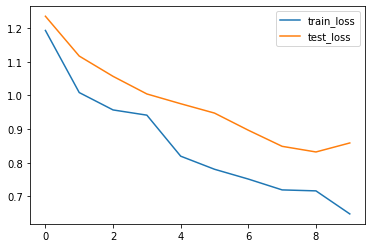

In [19]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend()
plt.show()

In [21]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # reshape the input
  inputs = inputs.view(-1, 7)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # reshape the input
  inputs = inputs.view(-1, 7)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
  
test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.8844, Test acc: 0.7748


In [22]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'.
  """
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    
  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()


Confusion matrix, without normalization
[[46  3  0  0  0  2  0  4]
 [ 1 17  0  0  2  1  0  1]
 [ 0  0  0  0  1  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  3  0  0  5  0  1  0]
 [ 0  0  0  0  0  5  0  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  1  0  0  4  0  0 12]]


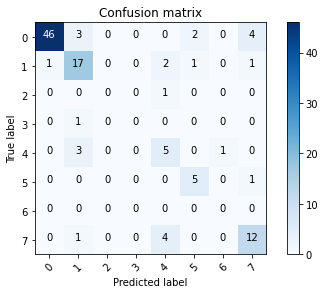

In [27]:
# Get all predictions in an array and plot confusion matrix

x_test = test_dataset.X_data.numpy()
y_test = test_dataset.y_data.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # Move data to GPU
  inputs = inputs.to(device)

  # Reshape the input
  inputs = inputs.view(-1, 7)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)

  # Update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(8)))